Epoch 1/25
47/47 [==============================] - 3s 11ms/step - loss: 0.2053
Epoch 2/25
47/47 [==============================] - 1s 11ms/step - loss: 0.0149
Epoch 3/25
47/47 [==============================] - 1s 11ms/step - loss: 0.0105
Epoch 4/25
47/47 [==============================] - 1s 11ms/step - loss: 0.0100
Epoch 5/25
47/47 [==============================] - 1s 11ms/step - loss: 0.0089
Epoch 6/25
47/47 [==============================] - 1s 12ms/step - loss: 0.0079
Epoch 7/25
47/47 [==============================] - 1s 11ms/step - loss: 0.0070
Epoch 8/25
47/47 [==============================] - 1s 11ms/step - loss: 0.0063
Epoch 9/25
47/47 [==============================] - 1s 11ms/step - loss: 0.0056
Epoch 10/25
47/47 [==============================] - 1s 11ms/step - loss: 0.0051
Epoch 11/25
47/47 [==============================] - 1s 11ms/step - loss: 0.0044
Epoch 12/25
47/47 [==============================] - 1s 11ms/step - loss: 0.0035
Epoch 13/25
47/47 [==================

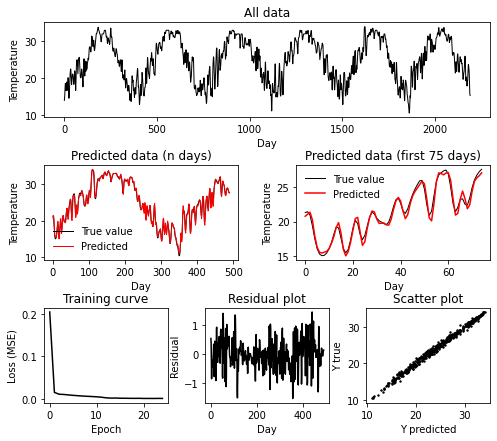

mse=0.23
r2=0.99


In [2]:
#
#
# LSTM weather prediction demo
# Written by: Dan R 2020
#
#



#
# Core Keras libraries
#
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
 
#
# For data conditioning
#
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt

#
# Make results reproducible
#
#import tensorflow
#tensorflow.random.set_seed(x)

from numpy.random import seed
seed(1)
#from tensorflow import set_random_seed
#set_random_seed(1)

import tensorflow
tensorflow.random.set_seed(1)

# 
# Other essential libraries
#
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from numpy import array

# Make our plot a bit formal
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 10}
plt.rc('font', **font)






#
# Set input number of timestamps and training days
#
n_timestamp = 10
train_days = 1500  # number of days to train from
testing_days = 500 # number of days to be predicted
n_epochs = 25
filter_on = 1


#
# Select model type
# 1: Single cell
# 2: Stacked
# 3: Bidirectional
#
model_type = 2





#url = "https://raw.githubusercontent.com/danrustia11/WeatherLSTM/master/data/weather_temperature_yilan.csv"
ure = "/content/drive/MyDrive/data/weather_temperature_82A750Wensan/82A750_item_day_20220509005843.csv"
dataset = pd.read_csv(url)
if filter_on == 1:
    dataset['Temperature'] = medfilt(dataset['Temperature'], 3)
    dataset['Temperature'] = gaussian_filter1d(dataset['Temperature'], 1.2)






#
# Set number of training and testing data
# 
train_set = dataset[0:train_days].reset_index(drop=True)
test_set = dataset[train_days: train_days+testing_days].reset_index(drop=True)
training_set = train_set.iloc[:, 1:2].values
testing_set = test_set.iloc[:, 1:2].values



#
# Normalize data first
#
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(testing_set)



#
# Split data into n_timestamp
#
def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp
        if end_ix > len(sequence)-1:
            break
        # i to end_ix as input
        # end_ix as target output
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


X_train, y_train = data_split(training_set_scaled, n_timestamp)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test, y_test = data_split(testing_set_scaled, n_timestamp)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)




if model_type == 1:
    # Single cell LSTM
    model = Sequential()
    model.add(LSTM(units = 50, activation='relu',input_shape = (X_train.shape[1], 1)))
    model.add(Dense(units = 1))
if model_type == 2:
    # Stacked LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
if model_type == 3:
    # Bidirectional LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))





#
# Start training
#
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, y_train, epochs = n_epochs, batch_size = 32)
loss = history.history['loss']
epochs = range(len(loss))
#
# Get predicted data
#
y_predicted = model.predict(X_test)

#
# 'De-normalize' the data
#
y_predicted_descaled = sc.inverse_transform(y_predicted)
y_train_descaled = sc.inverse_transform(y_train)
y_test_descaled = sc.inverse_transform(y_test)
y_pred = y_predicted.ravel()
y_pred = [round(yx, 2) for yx in y_pred]
y_tested = y_test.ravel()







#
# Show results
#
plt.figure(figsize=(8,7))

plt.subplot(3, 1, 1)
plt.plot(dataset['Temperature'], color = 'black', linewidth=1, label = 'True value')
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("All data")


plt.subplot(3, 2, 3)
plt.plot(y_test_descaled, color = 'black', linewidth=1, label = 'True value')
plt.plot(y_predicted_descaled, color = 'red',  linewidth=1, label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("Predicted data (n days)")

plt.subplot(3, 2, 4)
plt.plot(y_test_descaled[0:75], color = 'black', linewidth=1, label = 'True value')
plt.plot(y_predicted_descaled[0:75], color = 'red', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("Predicted data (first 75 days)")

plt.subplot(3, 3, 7)
plt.plot(epochs, loss, color='black')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.title("Training curve")

plt.subplot(3, 3, 8)
plt.plot(y_test_descaled-y_predicted_descaled, color='black')
plt.ylabel("Residual")
plt.xlabel("Day")
plt.title("Residual plot")

plt.subplot(3, 3, 9)
plt.scatter(y_predicted_descaled, y_test_descaled, s=2, color='black')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
plt.show()



mse = mean_squared_error(y_test_descaled, y_predicted_descaled)
r2 = r2_score(y_test_descaled, y_predicted_descaled)
print("mse=" + str(round(mse,2)))
print("r2=" + str(round(r2,2)))